# 1. Imports

In [1]:
import inflection
import pandas            as pd 
import numpy             as np
import matplotlib.pyplot as plt  
import seaborn           as sns         

from sklearn.feature_selection import RFE
from sklearn.model_selection   import train_test_split
from sklearn.linear_model      import LinearRegression
from sklearn.svm               import SVR

from sklearn.preprocessing     import RobustScaler

from IPython.core.display import display, HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:60% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

def adj_r2(r2,n_features):
    
    sample_size = df3.shape[0] 
    
    score = 1 - (1 - r2)*(sample_size - 1) / (sample_size - n_features - 1)
    
    return score


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [4]:
df1 = pd.read_csv('data/tennis_stats.csv', low_memory = False)

In [5]:
df1.head()

,Player,Year,FirstServe,FirstServePointsWon,FirstServeReturnPointsWon,SecondServePointsWon,SecondServeReturnPointsWon,Aces,BreakPointsConverted,BreakPointsFaced,BreakPointsOpportunities,BreakPointsSaved,DoubleFaults,ReturnGamesPlayed,ReturnGamesWon,ReturnPointsWon,ServiceGamesPlayed,ServiceGamesWon,TotalPointsWon,TotalServicePointsWon,Wins,Losses,Winnings,Ranking
0,Pedro Sousa,2016,0.88,0.50,0.38,0.50,0.39,0,0.14,7,7,0.43,2,9,0.11,0.38,8,0.50,0.43,0.50,1,2,39820,119
1,Roman Safiullin,2017,0.84,0.62,0.26,0.33,0.07,7,0.00,7,0,0.57,1,9,0.00,0.20,9,0.67,0.41,0.57,0,1,17334,381
2,Pedro Sousa,2017,0.83,0.60,0.28,0.53,0.44,2,0.38,10,8,0.40,1,19,0.16,0.34,17,0.65,0.45,0.59,4,1,109827,119
3,Rogerio Dutra Silva,2010,0.83,0.64,0.34,0.59,0.33,2,0.33,5,6,0.40,0,14,0.14,0.34,15,0.80,0.49,0.63,0,0,9761,125
4,Daniel Gimeno-Traver,2017,0.81,0.54,0.00,0.33,0.33,1,0.00,2,0,0.50,2,3,0.00,0.20,2,0.50,0.35,0.50,0,1,32879,272


# 2. Describe data

## Renaming Columns

In [6]:
df1.columns

Index(['Player', 'Year', 'FirstServe', 'FirstServePointsWon',
       'FirstServeReturnPointsWon', 'SecondServePointsWon',
       'SecondServeReturnPointsWon', 'Aces', 'BreakPointsConverted',
       'BreakPointsFaced', 'BreakPointsOpportunities', 'BreakPointsSaved',
       'DoubleFaults', 'ReturnGamesPlayed', 'ReturnGamesWon',
       'ReturnPointsWon', 'ServiceGamesPlayed', 'ServiceGamesWon',
       'TotalPointsWon', 'TotalServicePointsWon', 'Wins', 'Losses', 'Winnings',
       'Ranking'],
      dtype='object')

In [7]:
cols_old = ['Player', 'Year', 'FirstServe', 'FirstServePointsWon',
       'FirstServeReturnPointsWon', 'SecondServePointsWon',
       'SecondServeReturnPointsWon', 'Aces', 'BreakPointsConverted',
       'BreakPointsFaced', 'BreakPointsOpportunities', 'BreakPointsSaved',
       'DoubleFaults', 'ReturnGamesPlayed', 'ReturnGamesWon',
       'ReturnPointsWon', 'ServiceGamesPlayed', 'ServiceGamesWon',
       'TotalPointsWon', 'TotalServicePointsWon', 'Wins', 'Losses','Winnings','Ranking']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1721
Number of Columns: 24


## Data Types 

In [9]:
df1.dtypes

player                             object
year                                int64
first_serve                       float64
first_serve_points_won            float64
first_serve_return_points_won     float64
second_serve_points_won           float64
second_serve_return_points_won    float64
aces                                int64
break_points_converted            float64
break_points_faced                  int64
break_points_opportunities          int64
break_points_saved                float64
double_faults                       int64
return_games_played                 int64
return_games_won                  float64
return_points_won                 float64
service_games_played                int64
service_games_won                 float64
total_points_won                  float64
total_service_points_won          float64
wins                                int64
losses                              int64
winnings                            int64
ranking                           

## Check NA

In [10]:
df1.isna().sum()

player                            0
year                              0
first_serve                       0
first_serve_points_won            0
first_serve_return_points_won     0
second_serve_points_won           0
second_serve_return_points_won    0
aces                              0
break_points_converted            0
break_points_faced                0
break_points_opportunities        0
break_points_saved                0
double_faults                     0
return_games_played               0
return_games_won                  0
return_points_won                 0
service_games_played              0
service_games_won                 0
total_points_won                  0
total_service_points_won          0
wins                              0
losses                            0
winnings                          0
ranking                           0
dtype: int64

## Change Data Types

In [11]:
#year
df1['year'] = df1['year'].astype(int64)

## Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( exclude=['object'] )

In [13]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,year,2009.00,2017.00,8.00,2013.646717,2014.00,2.487295,-0.298632,-1.078604
1,first_serve,0.36,0.88,0.52,0.598053,0.60,0.054517,-0.024453,1.754697
2,first_serve_points_won,0.27,0.89,0.62,0.680738,0.69,0.070402,-1.092462,2.921027
3,first_serve_return_points_won,0.00,0.48,0.48,0.261673,0.27,0.056623,-0.817142,2.576312
4,second_serve_points_won,0.06,0.92,0.86,0.479733,0.49,0.066882,-1.108387,5.170326
5,second_serve_return_points_won,0.00,0.75,0.75,0.466432,0.48,0.068428,-1.455014,7.499550
6,aces,0.00,1185.00,1185.00,97.105171,34.00,137.925988,2.410634,7.996418
7,break_points_converted,0.00,1.00,1.00,0.369407,0.38,0.162939,0.552724,3.992389
8,break_points_faced,1.00,507.00,506.00,112.003486,55.00,119.213001,1.024637,-0.168915
9,break_points_opportunities,0.00,573.00,573.00,102.918071,41.00,122.725999,1.266877,0.567220


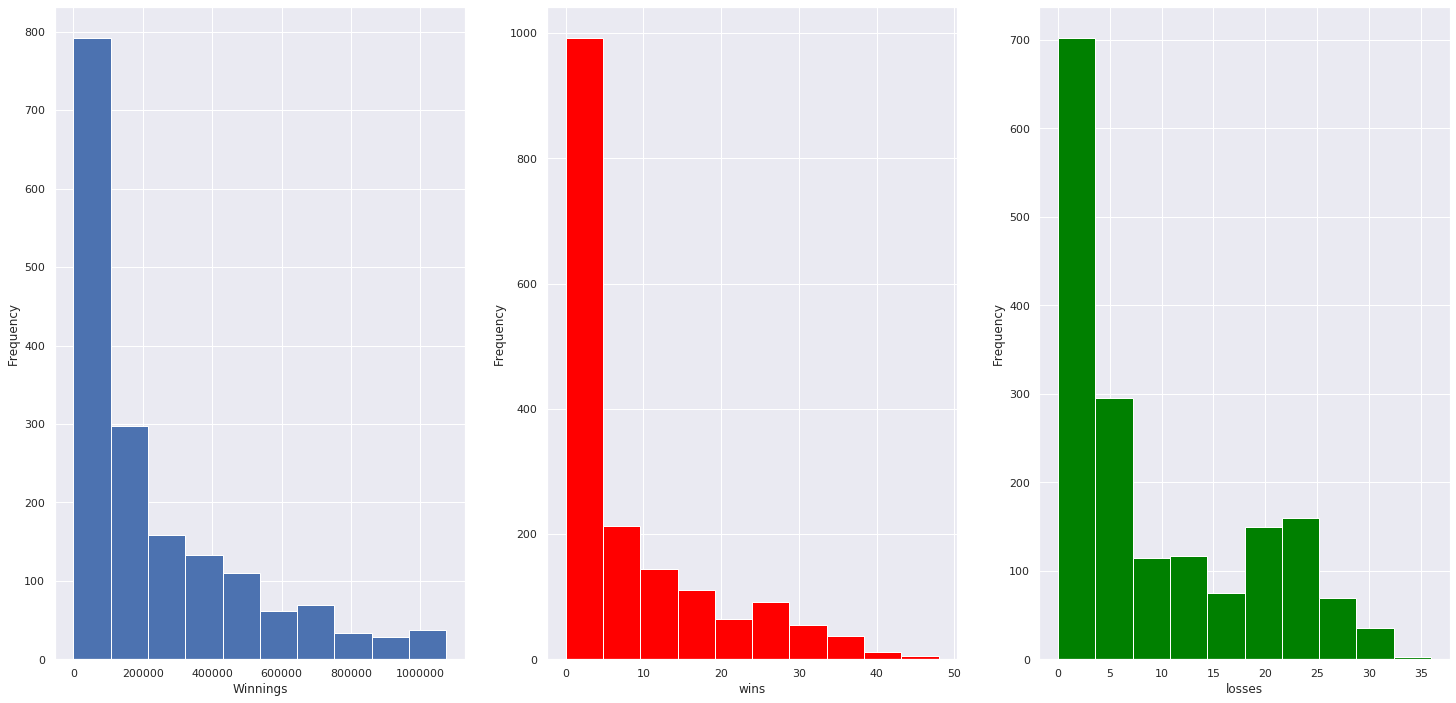

In [14]:
plt.subplot(1,3,1)
plt.hist(df1['winnings'])
plt.xlabel('Winnings')
plt.ylabel('Frequency');

plt.subplot(1,3,2)
plt.hist(df1['wins'], color = 'red')
plt.xlabel('wins')
plt.ylabel('Frequency');

plt.subplot(1,3,3)
plt.hist(df1['losses'], color = 'green')
plt.xlabel('losses')
plt.ylabel('Frequency');

Seems like **logarithmic** distribution 

# 3 Hypothesis

- **1** Players with less double faults win more games

- **2** Players that won first serve more often win more games

- **3** Players with more aces win more games

- **4** Players that break points more often win more games

- **5** Players that save break pointsm win more games

- **6** Players that won first serve more often win more games

# 4 Variable Filtering

Since columns like **wins**, **losses**, and **ranking** says nothing about in-game performance that could be used as advice, we're removing them from our analysis, once our goal is to understand what makes a good tennis player, and oubviously, winning most points and losing less, helps it for sure.

In [15]:
cols_drop = ['wins', 'losses', 'ranking', 'player', 'year']

df1.drop(cols_drop, axis = 1, inplace = True);

# 5 Exploratory Data Analysis

In [16]:
df2 = df1.copy()

## Univariate Analysis

### Response Variable

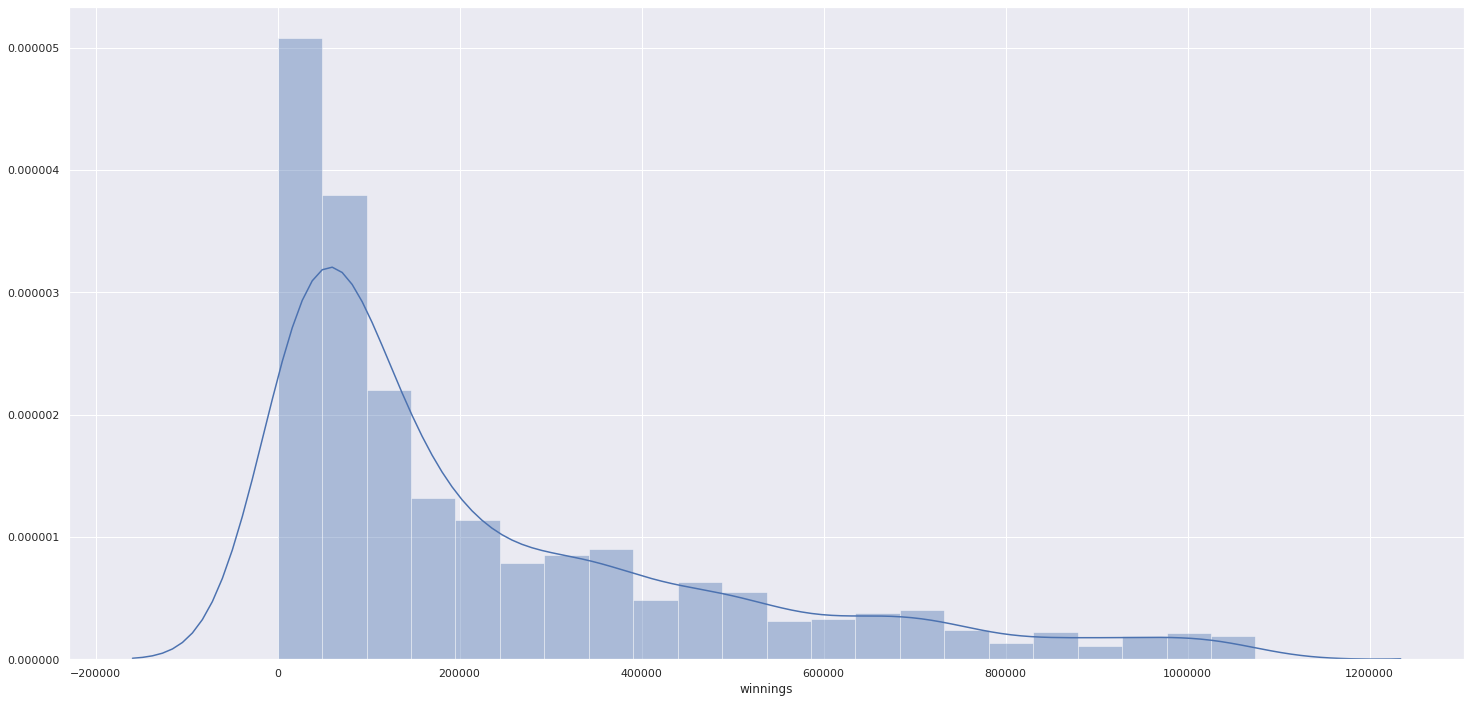

In [17]:
sns.distplot(df2['winnings'])

### Numerical Variables

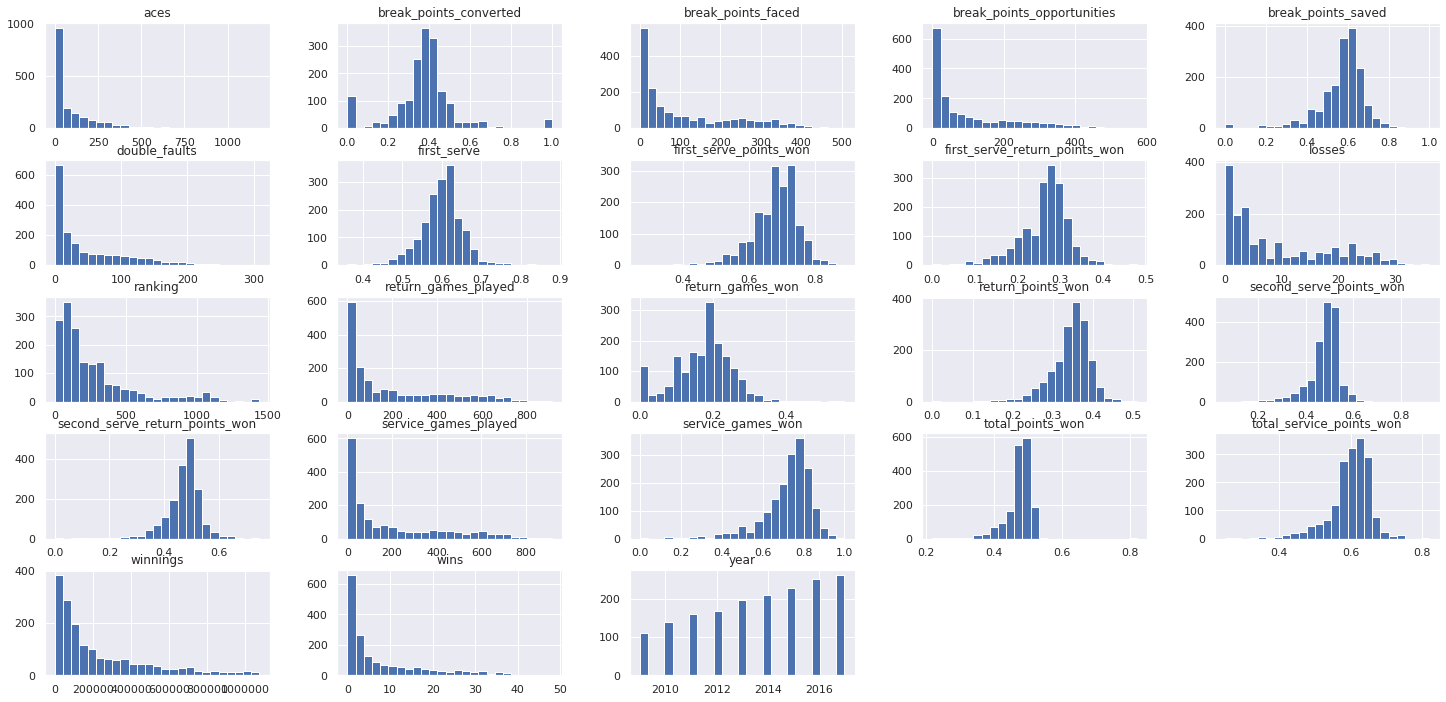

In [18]:
num_attributes.hist( bins=25 );

## Bivariate Analysis

### Players with less double faults win more games
### TRUE

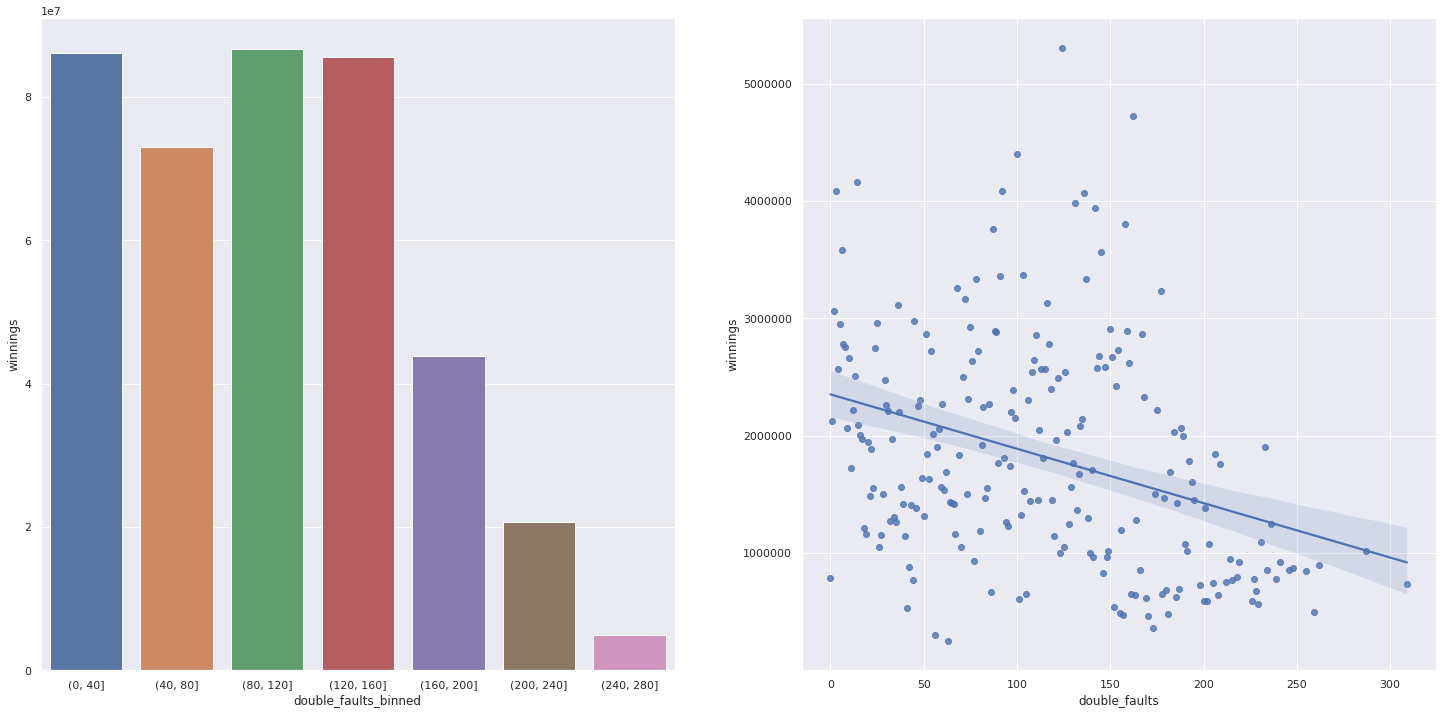

In [19]:
aux1 = df2[['double_faults', 'winnings']].groupby( 'double_faults' ).sum().reset_index()

plt.subplot( 1,2,1 )
bins = list( np.arange( 0, 320, 40) )
aux1['double_faults_binned'] = pd.cut( aux1['double_faults'], bins=bins )
aux2 = aux1[['double_faults_binned', 'winnings']].groupby( 'double_faults_binned' ).sum().reset_index()
sns.barplot(x = 'double_faults_binned', y = 'winnings', data = aux2);

plt.subplot( 1,2,2 )
sns.regplot( x ='double_faults', y='winnings', data=aux1 );

### Players that won points on first serve more often win more games 
### TRUE

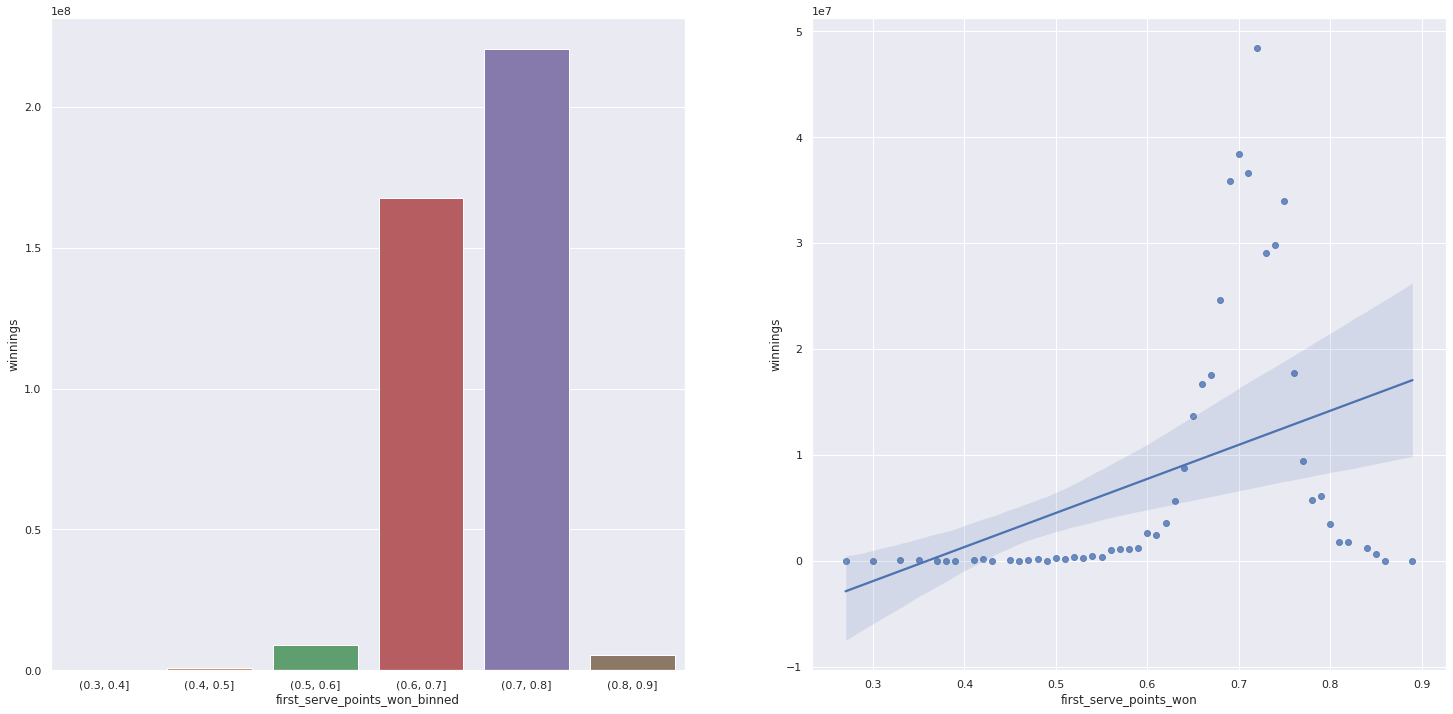

In [20]:
aux1 = df2[['first_serve_points_won', 'winnings']].groupby( 'first_serve_points_won' ).sum().reset_index()

plt.subplot( 1,2,1 )
bins = list( np.arange( 0.30, 0.90, 0.10) )
aux1['first_serve_points_won_binned'] = pd.cut( aux1['first_serve_points_won'], bins=bins )
aux2 = aux1[['first_serve_points_won_binned', 'winnings']].groupby( 'first_serve_points_won_binned' ).sum().reset_index()
sns.barplot(x = 'first_serve_points_won_binned', y = 'winnings', data = aux2);

plt.subplot( 1,2,2 )
sns.regplot( x ='first_serve_points_won', y='winnings', data=aux1 );

### Players with more aces win more games
### FALSE

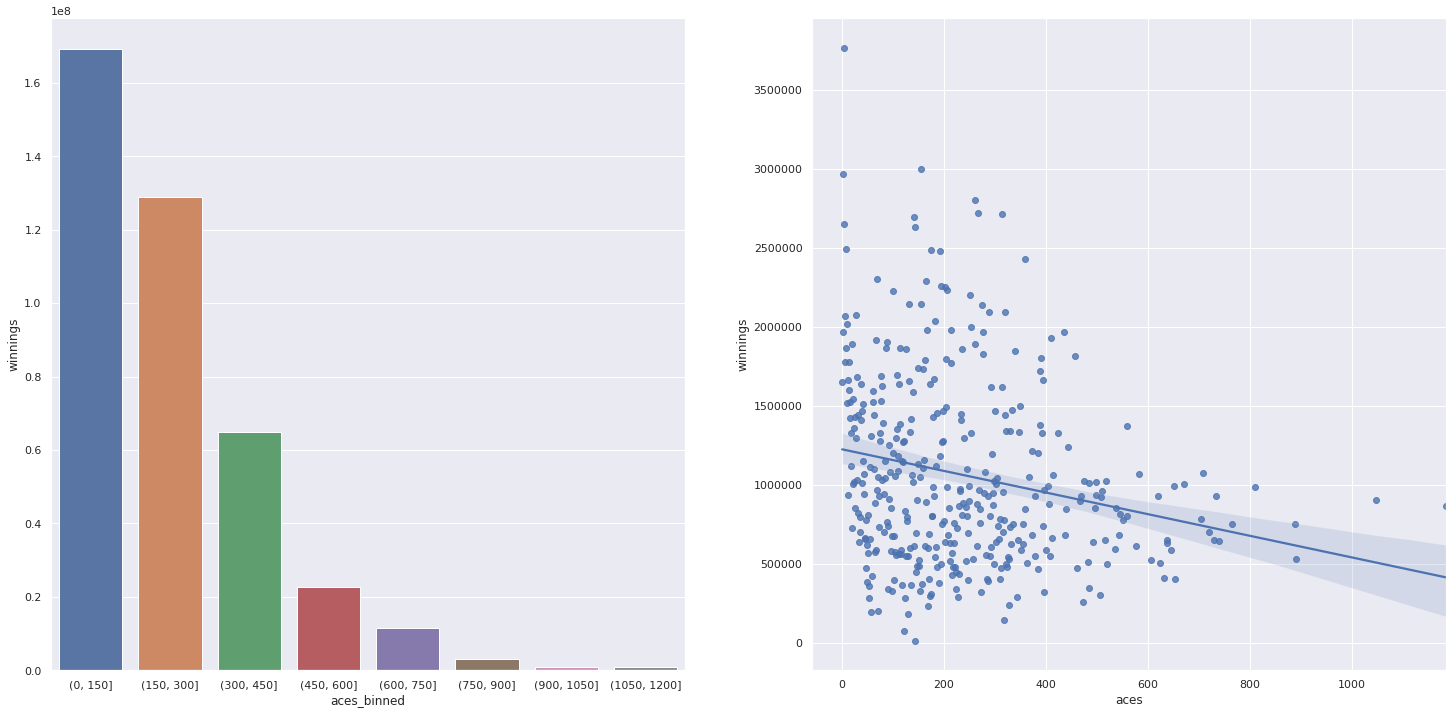

In [21]:
aux1 = df2[['aces', 'winnings']].groupby( 'aces' ).sum().reset_index()

plt.subplot( 1,2,1 )
bins = list( np.arange( 0, 1250, 150) )
aux1['aces_binned'] = pd.cut( aux1['aces'], bins=bins )
aux2 = aux1[['aces_binned', 'winnings']].groupby( 'aces_binned' ).sum().reset_index()
sns.barplot(x = 'aces_binned', y = 'winnings', data = aux2);

plt.subplot( 1,2,2 )
sns.regplot( x ='aces', y='winnings', data=aux1 );

### Players that break points more often win more games
## FALSE

In [22]:
df2.head()

,first_serve,first_serve_points_won,first_serve_return_points_won,second_serve_points_won,second_serve_return_points_won,aces,break_points_converted,break_points_faced,break_points_opportunities,break_points_saved,double_faults,return_games_played,return_games_won,return_points_won,service_games_played,service_games_won,total_points_won,total_service_points_won,winnings
0,0.88,0.50,0.38,0.50,0.39,0,0.14,7,7,0.43,2,9,0.11,0.38,8,0.50,0.43,0.50,39820
1,0.84,0.62,0.26,0.33,0.07,7,0.00,7,0,0.57,1,9,0.00,0.20,9,0.67,0.41,0.57,17334
2,0.83,0.60,0.28,0.53,0.44,2,0.38,10,8,0.40,1,19,0.16,0.34,17,0.65,0.45,0.59,109827
3,0.83,0.64,0.34,0.59,0.33,2,0.33,5,6,0.40,0,14,0.14,0.34,15,0.80,0.49,0.63,9761
4,0.81,0.54,0.00,0.33,0.33,1,0.00,2,0,0.50,2,3,0.00,0.20,2,0.50,0.35,0.50,32879


### Players that save break pointsm win more games

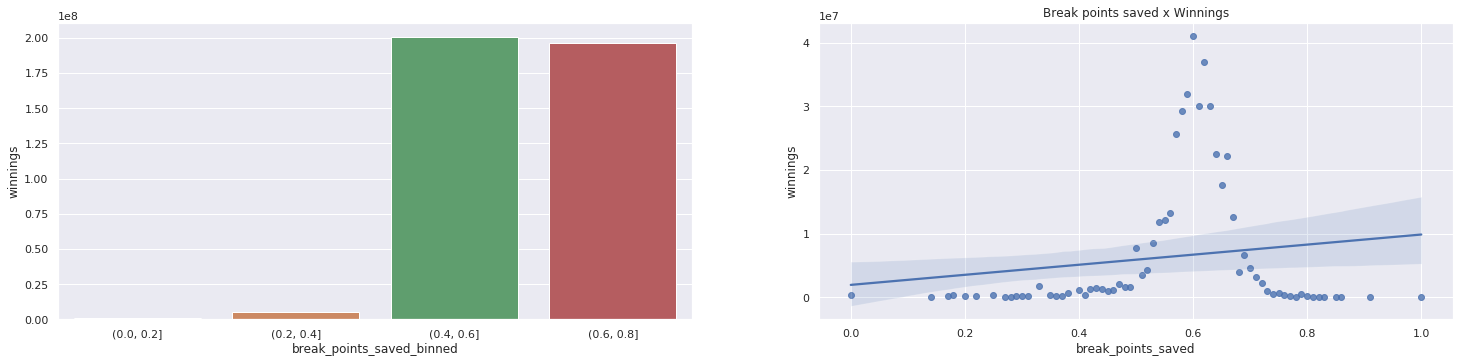

In [23]:
aux1 = df2[['break_points_saved', 'winnings']].groupby( 'break_points_saved' ).sum().reset_index()

plt.subplot( 2,2,1 )
bins = list( np.arange( 0, 1, 0.20) )
aux1['break_points_saved_binned'] = pd.cut( aux1['break_points_saved'], bins=bins )
aux2 = aux1[['break_points_saved_binned', 'winnings']].groupby( 'break_points_saved_binned' ).sum().reset_index()
sns.barplot(x = 'break_points_saved_binned', y = 'winnings', data = aux2);

plt.subplot( 2,2,2 )
sns.regplot( x ='break_points_saved', y='winnings', data=aux1 )
plt.title('Break points saved x Winnings');


### Players that won first serve more often win more games

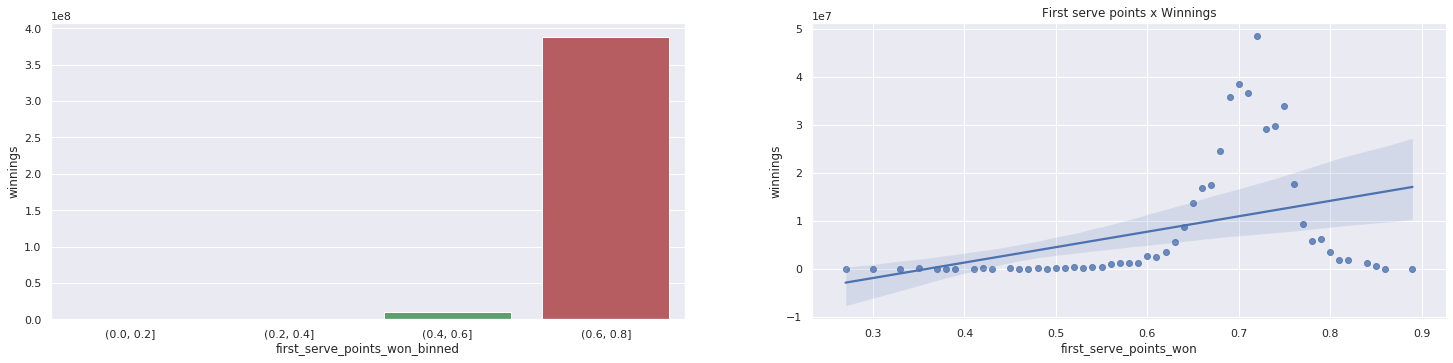

In [24]:
aux1 = df2[['first_serve_points_won', 'winnings']].groupby( 'first_serve_points_won' ).sum().reset_index()

plt.subplot( 2,2,1 )
bins = list( np.arange( 0, 1, 0.20) )
aux1['first_serve_points_won_binned'] = pd.cut( aux1['first_serve_points_won'], bins=bins )
aux2 = aux1[['first_serve_points_won_binned', 'winnings']].groupby( 'first_serve_points_won_binned' ).sum().reset_index()
sns.barplot(x = 'first_serve_points_won_binned', y = 'winnings', data = aux2);

plt.subplot( 2,2,2 )
sns.regplot( x ='first_serve_points_won', y='winnings', data=aux1 )
plt.title('First serve points x Winnings');


# 6 Data Preparation

In [25]:
df3 = df2.copy()

## 6.1 Checking 

In [26]:
df_prepare = df3[['service_games_played', 'return_games_played', 'break_points_faced', 'aces',
             'break_points_opportunities', 'double_faults']]


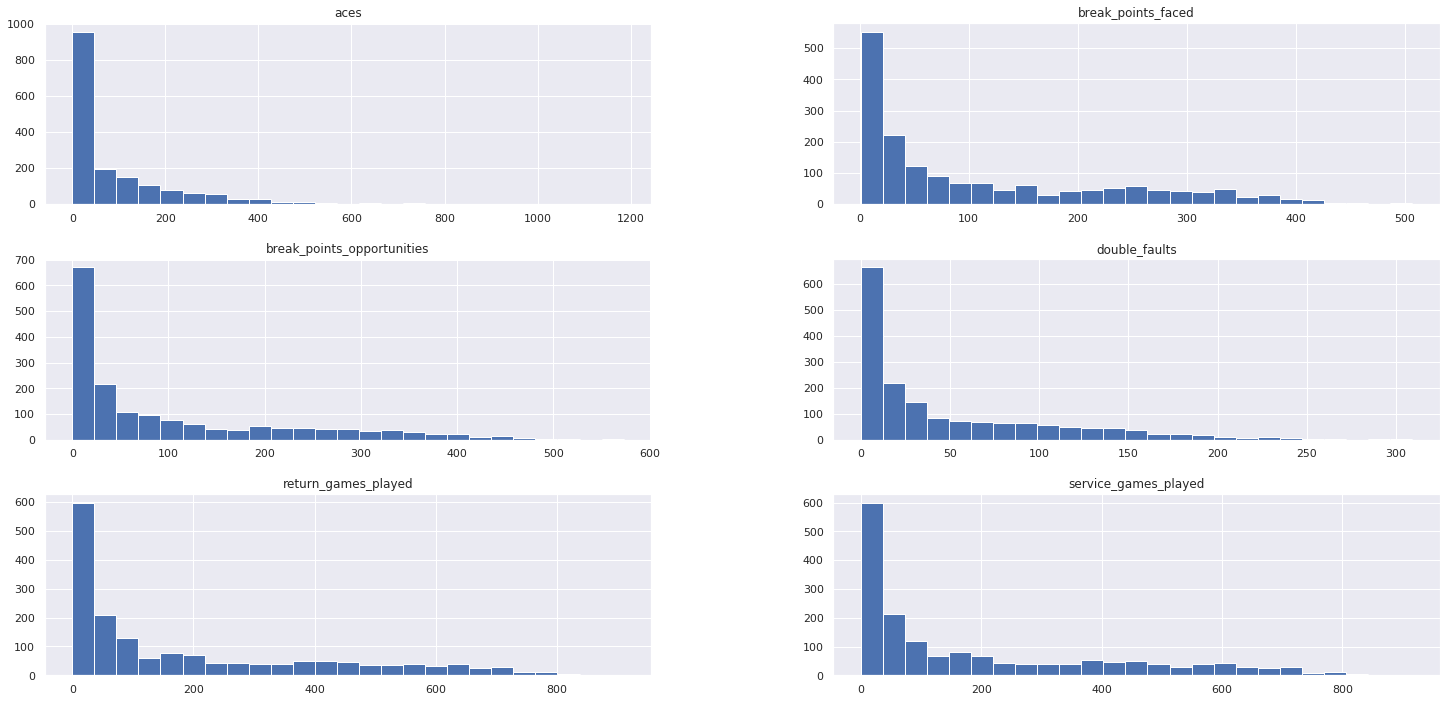

In [27]:
df_prepare.hist(bins = 25);

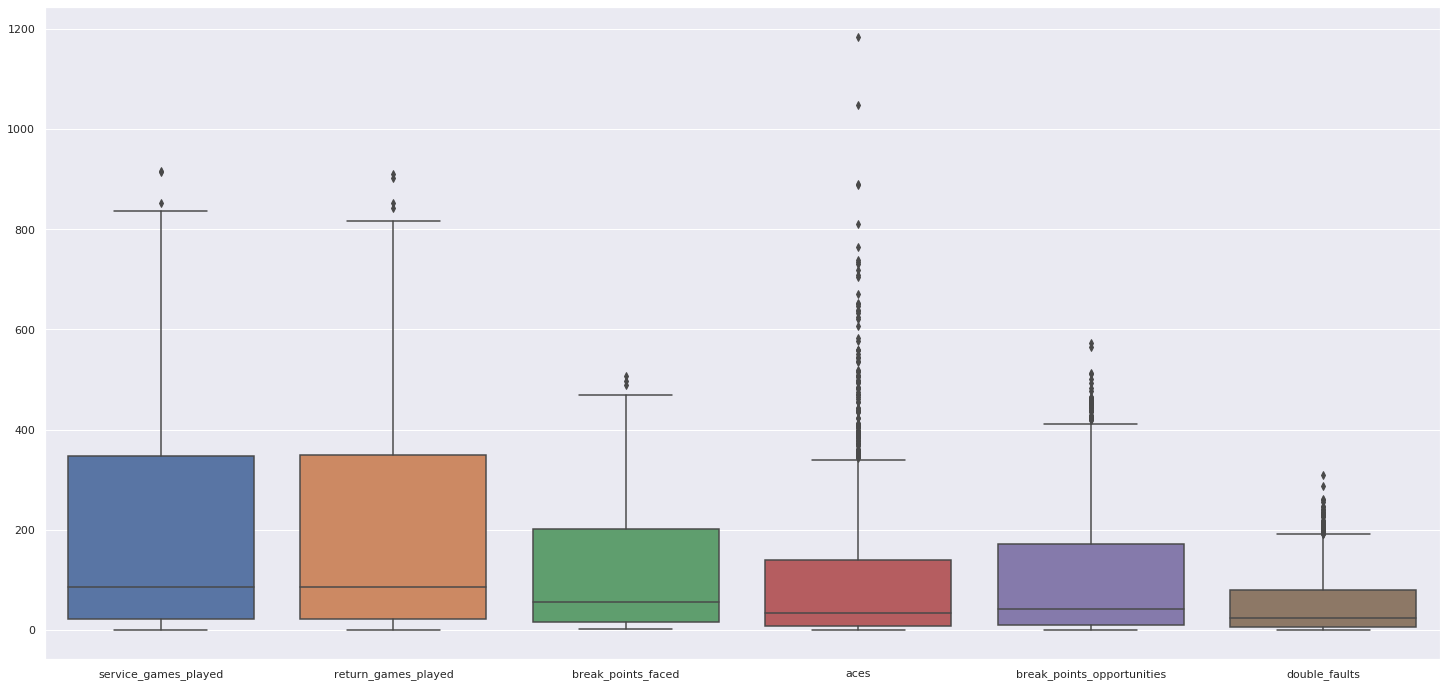

In [28]:
sns.boxplot(data = df_prepare);

## 6.2 Rescaling

### 6.1.1 Robust Scaller

Since the features that need to be scaled (range greater than 1) all have outliers, 
and also are not normally distributed, we are using **robust scaller** on them, just as follow:

$X_i = \frac{X_i - Q_1(x)}{Q_3(x) - Q_1(x)}$

In [29]:
rs = RobustScaler()

#service games played
df3['service_games_played'] = rs.fit_transform( df3[['service_games_played']].values)

#return games played
df3['return_games_played'] = rs.fit_transform( df3[['return_games_played']].values)

#break points faced
df3['break_points_faced'] = rs.fit_transform( df3[['break_points_faced']].values)

#aces
df3['aces'] = rs.fit_transform( df3[['aces']].values)

#break points opportunities
df3['break_points_opportunities'] = rs.fit_transform( df3[['break_points_opportunities']].values)

#double faults
df3['double_faults'] = rs.fit_transform( df3[['double_faults']].values)

## 6.3 Target Variable

In [30]:
df3['winnings'] = np.log1p( df3['winnings'] )

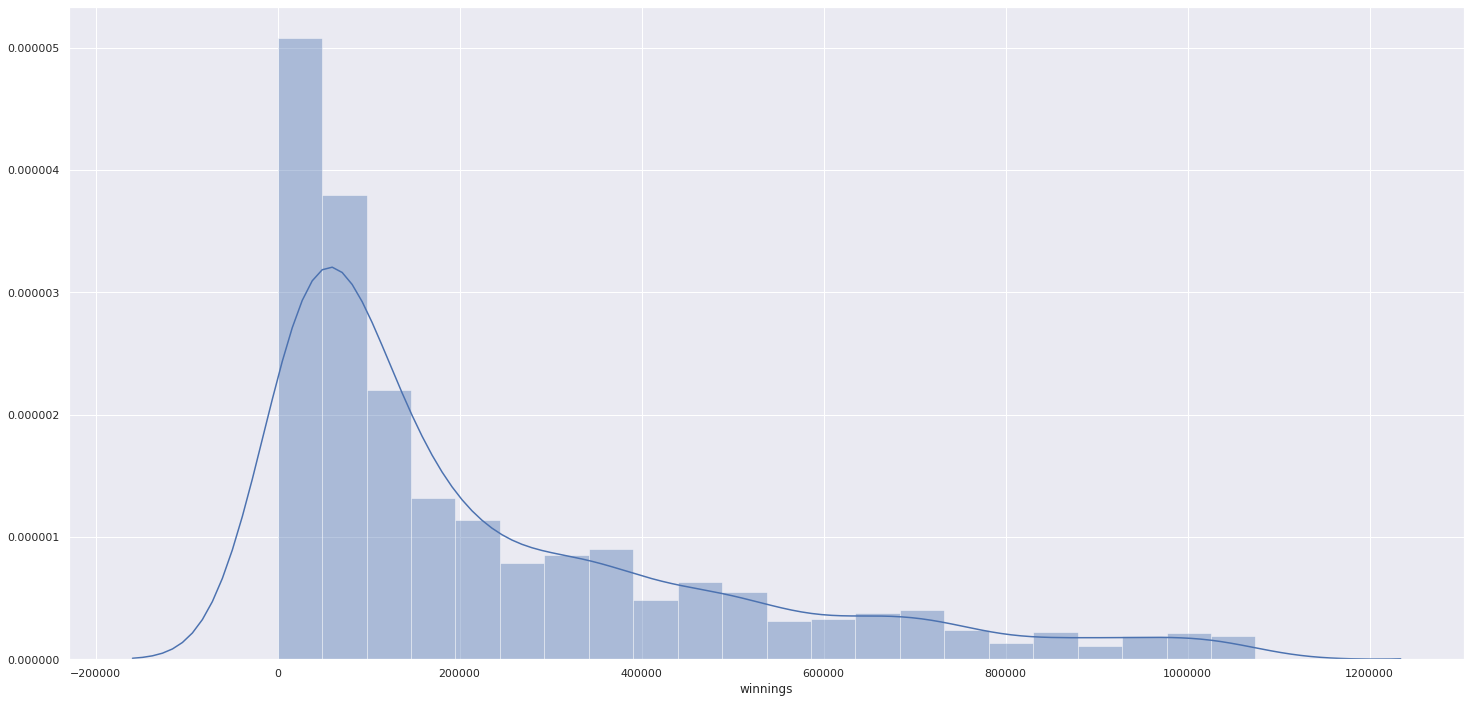

In [31]:
sns.distplot(df2['winnings']);

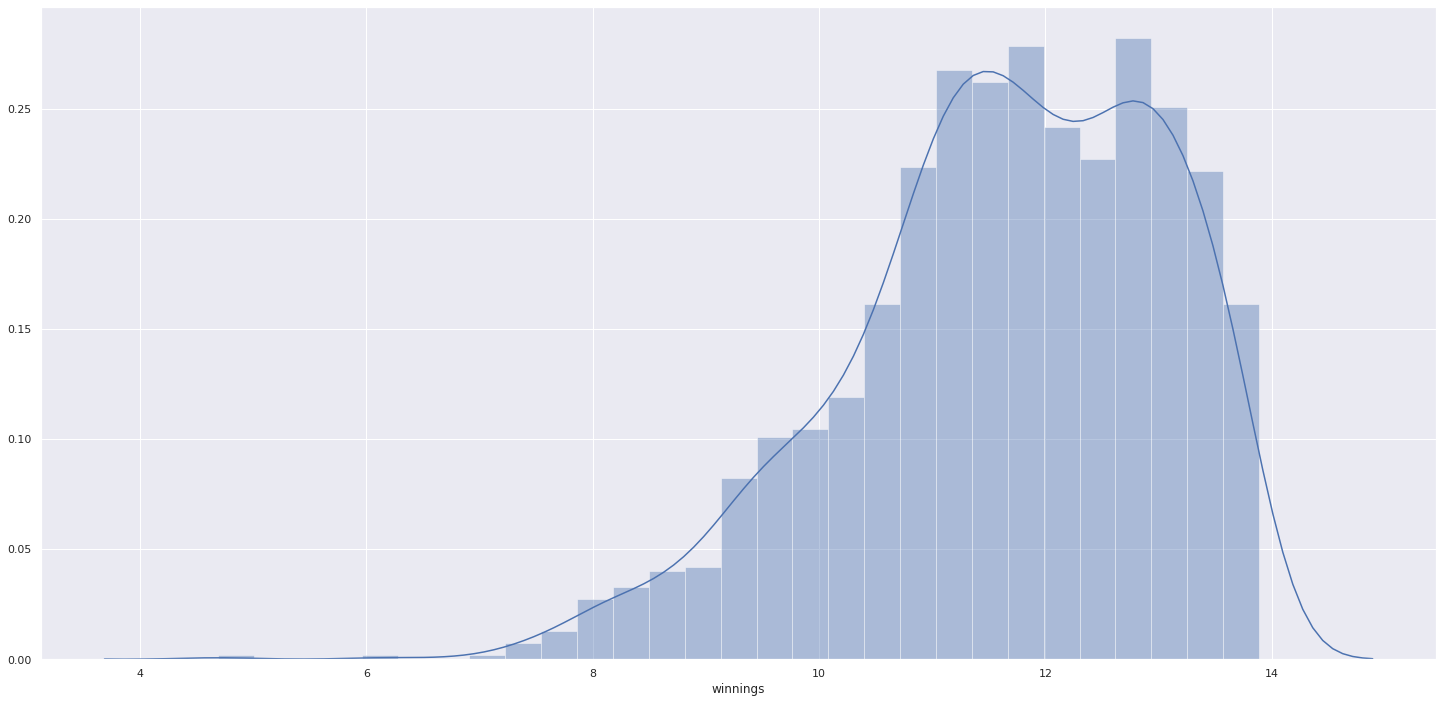

In [32]:
sns.distplot(df3['winnings']);

# 7 Feature Selection

In [33]:
df4 = df3.copy()

## 7.1 Recursive Feature Elimination

In [41]:
X = df4.drop('winnings', axis=1)
y = df4['winnings'].values

estimator = SVR(kernel="linear")

rfe = RFE(estimator, n_features_to_select= 10 , step = 2)

rfe = rfe.fit(X, y)


In [86]:
print('RFE Selected Columns')
print(' ')

for i in range(X.shape[1]):
    
    if rfe.support_[i] == True:
        print(str(X.columns[i]))
        print('Rank: %.2f' % rfe.ranking_[i])
        print(' ')
    else:
        pass

RFE Selected Columns
 
second_serve_points_won
Rank: 1.00
 
second_serve_return_points_won
Rank: 1.00
 
break_points_converted
Rank: 1.00
 
break_points_faced
Rank: 1.00
 
break_points_opportunities
Rank: 1.00
 
return_games_played
Rank: 1.00
 
return_games_won
Rank: 1.00
 
service_games_won
Rank: 1.00
 
total_points_won
Rank: 1.00
 
total_service_points_won
Rank: 1.00
 


## 7.2 Wrapper Method (Boruta)